In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# download csv from https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv
data = pd.read_csv('data/130001_tokyo_covid19_patients.csv', parse_dates=['公表_年月日', '発症_年月日', '確定_年月日'], low_memory=False)

In [7]:
data = data[(data['公表_年月日'] >= '2020-09-01') & (data['公表_年月日'] < '2021-09-01')]

daily = data.groupby("公表_年月日").size().to_frame('count')

In [8]:
daily['7dmean'] = daily.rolling(window='7D').mean()

# ref. COVID-19感染報告者数に基づく簡易実効再生産数推定方法
# https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/2502-idsc/iasr-in/10465-496d04.html
def calc_ern(*args, **kwargs):
    return sum(args[0][-7:]) / sum(args[0][:7])

daily['ern'] = daily['count'].rolling(window='19D').apply(calc_ern)
daily['ernmean'] = daily['ern'].rolling(window='5D').mean()

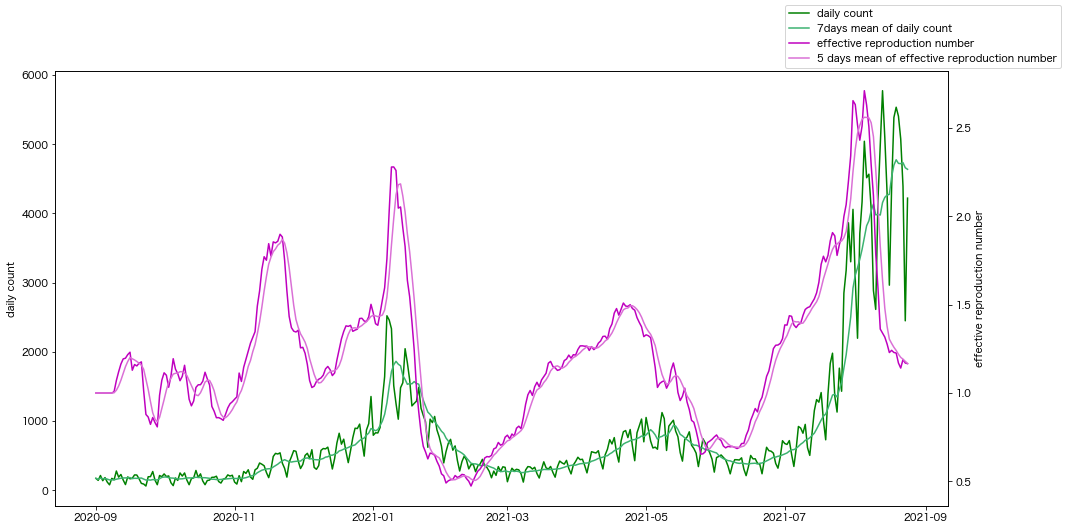

In [9]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(daily['count'], color='g', label='daily count')
ax1.plot(daily['7dmean'], color='mediumseagreen', label='7days mean of daily count')

ax1.set_ylabel('daily count')

ax2.plot(daily['ern'], color='m', label='effective reproduction number')
ax2.plot(daily['ernmean'], color='orchid', label='5 days mean of effective reproduction number')
ax2.set_ylabel('effective reproduction number')

fig.legend()
